# Repeated-MNIST: Visualization
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns
import torch

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan, torch])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/stochacq_fig1_repeated_mnist/", vanilla=True)

In [ ]:
get_any(results)

{'timestamp': 1642440921,
 'cmdline': ['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment_repeated_mnist.py',
  '--id=43'],
 'commit': '40e886b408a98d04481e15e66beebd65df720251',
 'github_url': '40e886b408a98d04481e15e66beebd65df720251',
 'experiment': '/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment_repeated_mnist.py',
 'job_id': 43,
 'worker_id': 43,
 'num_workers': 60,
 'config': {'seed': 8992,
  'experiment_data_config': {'id_dataset_name': 'MNIST',
   'id_repetitions': 2,
   'initial_training_set_size': 20,
   'validation_set_size': 4096,
   'validation_split_random_state': 0,
   'evaluation_set_size': 0,
   'add_dataset_noise': True,
   'ood_dataset_config': None},
  'acquisition_size': 10,
  'max_training_set': 120,
  'max_training_epochs': 300,
  'num_pool_samples': 100,
  'num_validation_samples': 20,
  'num_training_samples': 1,
  'device': 'cuda',
  'acquisition_function': 'batchbald_redux.acquisition_functions.Random',
  '

In [ ]:
df_raw = pd.DataFrame.from_dict(results, orient="index")

In [ ]:
df_raw.columns

Index(['timestamp', 'cmdline', 'commit', 'github_url', 'experiment', 'job_id',
       'worker_id', 'num_workers', 'config', 'log', 'dataset_info',
       'initial_training_set_indices', 'evaluation_set_indices', 'seed',
       'active_learning_steps', 'actual_name', 'actual_path', 'tag'],
      dtype='object')

In [ ]:
def flatten_dict(d: dict):
    result = {}
    for key, value in d.items():
        if isinstance(value, dict):
            result.update({f'{key}_{subkey}': value for subkey, value in flatten_dict(value).items()})
        else:
            result[key] = value
    return result

In [ ]:
df_raw.iloc[0].config

{'seed': 8992,
 'experiment_data_config': {'id_dataset_name': 'MNIST',
  'id_repetitions': 2,
  'initial_training_set_size': 20,
  'validation_set_size': 4096,
  'validation_split_random_state': 0,
  'evaluation_set_size': 0,
  'add_dataset_noise': True,
  'ood_dataset_config': None},
 'acquisition_size': 10,
 'max_training_set': 120,
 'max_training_epochs': 300,
 'num_pool_samples': 100,
 'num_validation_samples': 20,
 'num_training_samples': 1,
 'device': 'cuda',
 'acquisition_function': 'batchbald_redux.acquisition_functions.Random',
 'train_eval_model': 'batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel',
 'model_trainer_factory': 'batchbald_redux.models.MnistModelTrainer',
 'ensemble_size': 1,
 'temperature': 0.0,
 'coldness': 0.0,
 'stochastic_mode': None,
 'epig_bootstrap_type': 'BootstrapType.NO_BOOTSTRAP',
 'epig_bootstrap_factor': 1.0,
 'epig_dtype': torch.float64,
 'disable_training_augmentations': False,
 'cache_explicit_eval_model': False}

In [ ]:
def convert_to_rows(df, prefix):
    rows = []
    for idx, item in df.iterrows():
        exp_idx = f"{prefix}{idx}"
        config_part = {f"cfg_{key}": value for key, value in flatten_dict(item.config).items()}

        current_training_set_size = config_part["cfg_experiment_data_config_initial_training_set_size"]
        acquisition_batch_size = config_part["cfg_acquisition_size"]
        for step in item.active_learning_steps:
            best_epoch = step["training"]["best_epoch"]
            training_part = {f"training_{key}" : value for key, value in step["training"]["epochs"][best_epoch].items()}
            evaluation_part = {f"eval_{key}" : value for key, value in step["evaluation_metrics"].items()}
            idx = f"{exp_idx}_{current_training_set_size}"
            row = dict(idx=idx, exp_idx = exp_idx, **config_part, current_training_set_size=current_training_set_size, **training_part, **evaluation_part)

            #print(current_training_set_size)

            current_training_set_size += acquisition_batch_size
            #assert step["dataset"]["next_training_size"] == current_training_set_size
            #next_training_set_size = step["dataset"]["next_training_size"] 

            rows.append(row)

    return pd.DataFrame(rows)

df = convert_to_rows(df_raw, "")

In [ ]:
df.columns

Index(['idx', 'exp_idx', 'cfg_seed',
       'cfg_experiment_data_config_id_dataset_name',
       'cfg_experiment_data_config_id_repetitions',
       'cfg_experiment_data_config_initial_training_set_size',
       'cfg_experiment_data_config_validation_set_size',
       'cfg_experiment_data_config_validation_split_random_state',
       'cfg_experiment_data_config_evaluation_set_size',
       'cfg_experiment_data_config_add_dataset_noise',
       'cfg_experiment_data_config_ood_dataset_config', 'cfg_acquisition_size',
       'cfg_max_training_set', 'cfg_max_training_epochs',
       'cfg_num_pool_samples', 'cfg_num_validation_samples',
       'cfg_num_training_samples', 'cfg_device', 'cfg_acquisition_function',
       'cfg_train_eval_model', 'cfg_model_trainer_factory',
       'cfg_ensemble_size', 'cfg_temperature', 'cfg_coldness',
       'cfg_stochastic_mode', 'cfg_epig_bootstrap_type',
       'cfg_epig_bootstrap_factor', 'cfg_epig_dtype',
       'cfg_disable_training_augmentations', 'cfg

In [ ]:
df.cfg_acquisition_function.unique()

array(['batchbald_redux.acquisition_functions.Random',
       'batchbald_redux.acquisition_functions.StochasticBALD',
       'batchbald_redux.baseline_acquisition_functions.BADGE',
       'batchbald_redux.acquisition_functions.BALD'], dtype=object)

In [ ]:
def get_nice_method_name(row):
    method_name:str = row.cfg_acquisition_function
        
    prefix = "batchbald_redux.acquisition_functions."
    if method_name.startswith(prefix):
        method_name = method_name[len(prefix):]
        
    prefix = "batchbald_redux.baseline_acquisition_functions."
    if method_name.startswith(prefix):
        method_name = method_name[len(prefix):]
        
    if method_name == "StochasticBALD":
        prefix_length = len("StochasticMode.")
        method_name = row.cfg_stochastic_mode[prefix_length:] + "BALD"
    return method_name

df["method_name"] = df.apply(axis=1, func=get_nice_method_name)
df.method_name.unique()

array(['Random', 'PowerBALD', 'BADGE', 'BALD'], dtype=object)

Text(0.5, 0.98, 'BALD')

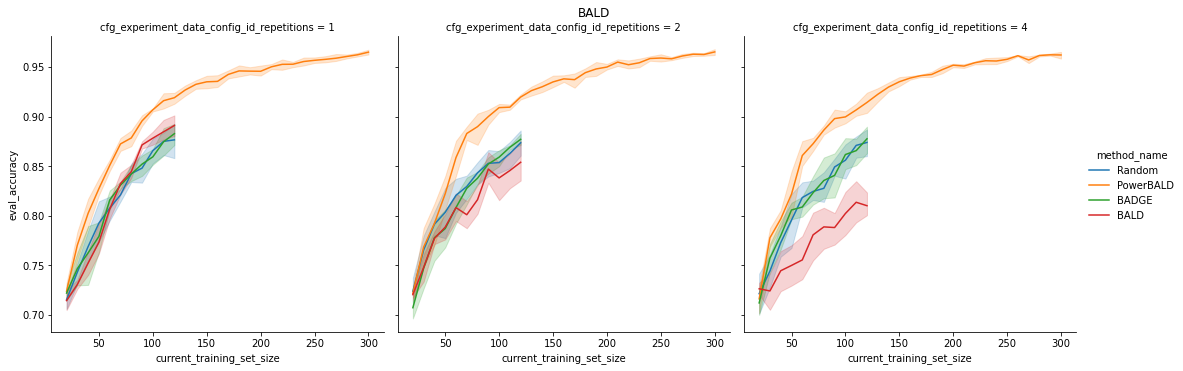

In [ ]:
sub_df = df
g = sns.relplot(data=sub_df, x="current_training_set_size", y="eval_accuracy", hue="method_name", col="cfg_experiment_data_config_id_repetitions", kind="line")
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Figure 1')